## Abstract Attributes

Not working yet.

In [120]:
def abstractattrs(*attrs):
    def wrapper(cls):
        
        def method(cls, *args, **kwargs):
            super(cls, cls).__init_subclass__(*args, **kwargs)
            for attr in attrs:
                if not hasattr(cls, attr):
                    raise RuntimeError(f'Class must have attribute {attr}.') 
                    
        setattr(cls, '__init_subclass__', classmethod(method))
        return cls
    return wrapper              

In [121]:
@abstractattrs('name', 'age')
class Base:
    def __init__(self, age=7):
        self.age = age 

In [122]:
class Child(Base):
    a = 'a'

RecursionError: maximum recursion depth exceeded while calling a Python object

In [118]:
class AbstractAttrs:
    
    def __init__(self, *args):
        print(args)
        self.args = list(args)
    
    @classmethod
    def __init_subclass__(cls, **kwargs):
        super().__init_subclass__(**kwargs)
#         if not hasattr(cls, f'_{cls.__name__}__attrs'):
#             print('no attrs')
        print('init subclass', AbstractAttrs._args())
        for arg in AbstractAttrs.args:
            assert hasattr(cls, arg), \
                f'{cls.__name__} must have class variable {arg}.'

In [119]:
class Callback(AbstractAttrs):
    pass

TypeError: _args() missing 1 required positional argument: 'self'

In [112]:
c = Callback('order', 'is_val')

('order', 'is_val')


In [113]:
class NewCallback(Callback):
    
    def __init__(self, a, order=3):
        self.a = a
        self.order = order

pre super
NewCallback
no attrs


In [107]:
nc = NewCallback('a', 'my_order')

In [108]:
nc

In [109]:
nc._attrs

['order', 'val_loop']

In [15]:
from abc import ABC, abstractmethod, abstractproperty

In [16]:
class Abstract(ABC):
    def __init__(self, a):
        self.a = a
    @abstractmethod
    def walk(self):
        pass
    
    @abstractproperty
    def b(self):
        pass

In [51]:
class Child(Abstract):
    b = 3
        
    def walk(self):
        return self.a
    
#     def b(self):
#         print('in b, method not prop')
#         return self.a*2

In [52]:
c = Child(3)

In [54]:
c.b

3

## Metaclass approach

This seems more promising.

In [51]:
from inspect import ismethod, getattr_static

In [133]:
def hasstatic(cls, meth_name):
    """Check if a class possesses a staticmethod of a given name. Similar to
    hasattr
    
    Parameters
    ----------
    cls: Type or any
        A class or an instance (seems to work on both, though more extensive
        testing may be needed for more complex scenarios).
    meth_name: str
        Name of method to check. If the class/instance does not contain any
        attribute with this name, function returns False.
        
    Returns
    -------
    bool: True if `cls` has a staticmethod with name `meth_name`.
    """
    return isinstance(getattr_static(cls, meth_name, None), staticmethod)

In [134]:
class Foo:
    def __init__(self, a):
        self.a = a
    @staticmethod
    def bar(self):
        return 'bar'

In [135]:
hasstatic(Foo, 'bar')

True

In [136]:
hasstatic(Foo, '__init__')

False

In [137]:
hasstatic(Foo(3), 'bar')

True

In [138]:
hasstatic(Foo(3), '__init__')

False

In [139]:
hasstatic(Foo(3), 'fake')

False

In [199]:
class AbstractAttrs(type):
    """Basically the attribute equivalent of abc.abstractmethod: this allows 
    us to define an abstract parent class that requires its children to 
    possess certain class and/or instance attributes. This differs from
    abc.abstractproperty in a few ways:
    
    1. abstractproperty ignores instance attributes. AbstractAttrs lets us
    specify required instance attributes and/or class attributes and
    distinguish between the two.
    2. abstractproperty considers the requirement fulfilled by methods,
    properties, and class attributes. AbstractAttrs does not allow methods 
    (including classmethods and staticmethods) to fulfill either requirement,
    though properties can fulfill either.
    
    Examples
    --------
    This class defines required instance attributes and class attributes, 
    but you can also specify one or the other. If you don't care whether an
    attribute is at the class or instance level, you can simply use
    @abc.abstractproperty.
    
    class Parent(metaclass=AbstractAttrs, inst_attrs=['name'], 
                 class_attrs=['order', 'is_val']):
        pass
    """

    def __new__(cls, name, bases, methods, **meta_kwargs):
        """This provides user-defined parent classes with an 
        `__init_subclass__` method that checks for class attributes. Errors
        will occur when the parent class is defined, not when instances of it
        are constructed.
        """
        class_ = type.__new__(cls, name, bases, methods)
        class_attrs = meta_kwargs.get('class_attrs', [])
        inst_attrs = meta_kwargs.get('inst_attrs', [])
        
        def __init_subclass__(cls, **kwargs):
            super().__init_subclass__(**kwargs)
            for attr in class_attrs:
                # TypeError maintains consistency with abstractmethod.
                # Remaining checks occur at instantiation.
                if not hasattr(cls, attr):
                    raise TypeError(f'{cls} must have class attribute '
                                    f'`{attr}`.')
        
        # Make sure we distinguish between the abstract parent class that 
        # defines an interface and the child classes that implement it. The
        # abstract parent should not define the required attributes: it merely
        # enforces the requirement that its children do. We want the children
        # to inherit class_attrs and inst_attrs without overwriting them when
        # their own __new__ is called, so that AbstractAttrs.__call__ can
        # use them for validation. Only change this if you're very confident
        # you understand the repercussions.
        if class_attrs or inst_attrs:
            class_.__init_subclass__ = classmethod(__init_subclass__)
            class_._is_parent = True
            class_.class_attrs = class_attrs
            class_.inst_attrs = inst_attrs
        else:
            class_._is_parent = False
        return class_

    def __call__(cls, *args, **kwargs):
        """This is called when we create instances of our classes. Parents are
        initialized normally, while children undergo a series of checks for
        each of our required attributes.
        """
        inst = cls.__new__(cls, *args, **kwargs)
        if not isinstance(inst, cls): return inst
        
        inst.__init__(*args, **kwargs)
        if cls._is_parent: return inst
        
        # Validate children.
        for attr in inst.inst_attrs:
            # TypeError maintains consistency with abstractmethod.
            if not hasattr(inst, attr):
                raise TypeError(f'Instances of {type(inst)} must '
                                f'have instance attribute `{attr}`.')
            elif ismethod(getattr(inst, attr)):
                raise TypeError(f'`{attr}` must be an instance attribute, '
                                'not a method.')
                
        # In AbstractAttrs.__new__, methods are still unbound so we couldn't
        # easily check this until now.
        for attr in inst.class_attrs:
            # `ismethod` must check inst, not cls (cls.method is a function 
            # while inst.method is a method). staticmethod can be retrieved 
            # from either.
            if ismethod(getattr(inst, attr)) or hasstatic(inst, attr):
                raise TypeError(f'`{attr}` must be a class attribute, not a '
                                'method.')
            elif isinstance(getattr(cls, attr), property):
                raise TypeError(
                    f'`{attr}` must be a class attribute, not a property. '
                    'Properties fulfill instance attribute requirements but '
                    'not class attribute requirements.'
                )
        return inst

In [175]:
class Parent(metaclass=AbstractAttrs, inst_attrs=['name'],
             class_attrs=['order', 'is_val']):
    pass

In [176]:
p = Parent()

In [177]:
p.class_attrs, p.inst_attrs, p._is_parent

(['order', 'is_val'], ['name'], True)

In [178]:
# Implements required class vars but not required inst vars. Error will be
# thrown on object instantiation, not class definition.
class Child(Parent):
    
    order = 33
    is_val = True
    
    def __init__(self, a):
        self.a = a
        print('child init')

In [179]:
c = Child(4)
c

child init


TypeError: Instances of <class '__main__.Child'> must have instance attribute `name`.

In [180]:
# Possesses one of the required class vars but the other is defined as an
# instance var. Throws error at class definition. If we want to accept either,
# we could use abc.abstractmethod or simply define our instance variables.
class BadChild(Parent):
    
    order = 1
    
    def __init__(self, b, is_val):
        self.b = b
        self.is_val = is_val

TypeError: <class '__main__.BadChild'> must have class attribute `is_val`.

In [181]:
# Trying to sneakily use a method to fulfill an instance var requirement.
class TrickyChild(Parent):
    
    order = 33
    is_val = True
    
    def __init__(self, a):
        self.a = a
        print('child init')
        
    def name(self):
        print('in name')

In [182]:
tc = TrickyChild(44)

child init


TypeError: `name` must be an instance attribute, not a method.

In [183]:
# Trying to use a property to fulfill an instance var requirement 
# (acceptable).
class TrickyChild2(Parent):
    
    order = 33
    is_val = True
    
    def __init__(self, a):
        self.a = a
        print('child init')
        
    @property
    def name(self):
        return 'name'

In [184]:
tc = TrickyChild2(44)

child init


In [185]:
tc.name

'name'

In [186]:
TrickyChild2(1).name

child init


'name'

In [187]:
TrickyChild2.name

In [188]:
# Trying to use a property to fulfill a class var requirement. UNacceptable.
class TrickyChild3(Parent):
    
    order = 33
    
    def __init__(self, a, name):
        self.a = a
        self.name = name
        print('child init')
        
    @property
    def is_val(self):
        return 'is val'

In [189]:
tc = TrickyChild3(44, 'sam')

child init


TypeError: `is_val` must be a class attribute, not a property. Properties fulfill instance attribute requirements but not class attribute requirements.

In [190]:
# Trying to use a method to fulfill a class var req. UNacceptable.
class TrickyChild4(Parent):
    
    order = 33
    
    def __init__(self, a, name):
        self.a = a
        self.name = name
        print('child init')
        
    def is_val(self):
        print(self, type(self))
        return self.a, 'is_val'
        
    def testing(self):
        return self.a*2, 'is_val'

In [191]:
tc = TrickyChild4(44, 'sam')

child init


TypeError: `is_val` must be a class attribute, not a method.

In [192]:
# Trying to use a classmethod to fulfill a class var req. UNacceptable.
class TrickyChild5(Parent):
    
    order = 33
    
    def __init__(self, a, name):
        self.a = a
        self.name = name
        print('child init')
        
    @classmethod
    def is_val(cls):
        return 'testing classmethod'

In [193]:
tc = TrickyChild5(44, 'sam')

child init


TypeError: `is_val` must be a class attribute, not a method.

In [194]:
# Trying to use a staticmethod to fulfill a class var req. UNacceptable.
class TrickyChild6(Parent):
    
    order = 33
    
    def __init__(self, a, name):
        self.a = a
        self.name = name
        print('child init')
        
    @staticmethod
    def is_val(a):
        return a

In [195]:
tc = TrickyChild6(44, 'sam')

child init


TypeError: `is_val` must be a class attribute, not a method.

In [196]:
# Implements desired interface.
class GoodChild(Parent):
    
    order = 100
    is_val = False
    
    def __init__(self, name):
        self.name = name
        
    def walk(self):
        return self.order, self.is_val, self.name

In [197]:
ian = GoodChild('Ian')

In [198]:
ian.walk()

(100, False, 'Ian')

## Data

Get top 1000 sites for lsh dict testing.

In [401]:
r = requests.get('https://dataforseo.com/top-1000-websites')
soup = bs(r.content)

In [411]:
s3_path = ('s3://commoncrawl/projects/hyperlinkgraph/cc-main-2018-aug-sep-oct'
           '/domain/cc-main-2018-aug-sep-oct-domain-ranks.txt.gz')
df = pd.read_csv(s3_path, nrows=10_000, sep='\t')

In [421]:
def _process_hostname(host):
    parts = host.split('.')
    return '.'.join(parts[1:]) + '.' + parts[0]

In [423]:
df['host'] = df['#host_rev'].apply(_process_hostname)

## LSH

In [399]:
from bs4 import BeautifulSoup as bs
from datasketch import lsh, MinHashLSH, MinHash, MinHashLSHForest
import numpy as np
import pandas as pd
import requests
from tldextract import extract

from htools import *

In [221]:
set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['minhash', 'is', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])

m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
m3 = MinHash(num_perm=128)
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))
for d in set3:
    m3.update(d.encode('utf8'))

# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
lsh.insert("m3", m3)
result = lsh.query(m1)
result

['m2', 'm3']

In [203]:
def ngrams(word, n=3, step=1, drop_last=False):
    """To get non-overlapping sequences, pass in same value for `step` as `n`."""
    stop = max(1, step+len(word)-n)
    ngrams_ = []
    for i in range(0, stop, step):
        ngrams_.append(word[i:i+n])
    if drop_last and len(ngrams_[-1]) < n: ngrams_ = ngrams_[:-1]
    return ngrams_

In [204]:
w = 'dinosaur'
tw = 'I'
ws = ['dino', 'rhino', 'dog', 'cat', 'lion', 'tyrannosaurus rex',
      'tiger', 'owl', 'rhinocerous', 'kino']
s = 'The mailman was running late today, possibly due to the heavy '\
    'snowfall from the previous night.'

In [205]:
ngrams(w)

['din', 'ino', 'nos', 'osa', 'sau', 'aur']

In [206]:
ngrams(w, 2)

['di', 'in', 'no', 'os', 'sa', 'au', 'ur']

In [207]:
ngrams(w, 3, 3)

['din', 'osa', 'ur']

In [208]:
ngrams(w, 3, 3, True)

['din', 'osa']

In [209]:
ngrams(s)

['The',
 'he ',
 'e m',
 ' ma',
 'mai',
 'ail',
 'ilm',
 'lma',
 'man',
 'an ',
 'n w',
 ' wa',
 'was',
 'as ',
 's r',
 ' ru',
 'run',
 'unn',
 'nni',
 'nin',
 'ing',
 'ng ',
 'g l',
 ' la',
 'lat',
 'ate',
 'te ',
 'e t',
 ' to',
 'tod',
 'oda',
 'day',
 'ay,',
 'y, ',
 ', p',
 ' po',
 'pos',
 'oss',
 'ssi',
 'sib',
 'ibl',
 'bly',
 'ly ',
 'y d',
 ' du',
 'due',
 'ue ',
 'e t',
 ' to',
 'to ',
 'o t',
 ' th',
 'the',
 'he ',
 'e h',
 ' he',
 'hea',
 'eav',
 'avy',
 'vy ',
 'y s',
 ' sn',
 'sno',
 'now',
 'owf',
 'wfa',
 'fal',
 'all',
 'll ',
 'l f',
 ' fr',
 'fro',
 'rom',
 'om ',
 'm t',
 ' th',
 'the',
 'he ',
 'e p',
 ' pr',
 'pre',
 'rev',
 'evi',
 'vio',
 'iou',
 'ous',
 'us ',
 's n',
 ' ni',
 'nig',
 'igh',
 'ght',
 'ht.']

In [210]:
def lsh_hash_word(word, num_perm=128, **ngram_kwargs):
    mhash = MinHash(num_perm=num_perm)
    for ng in ngrams(word, **ngram_kwargs):
        mhash.update(ng.encode('utf8'))
    return mhash

In [211]:
m = lsh_hash_word(w)

In [212]:
forest = MinHashLSHForest(num_perm=128)

for i, word in enumerate(ws):
    forest.add(i, lsh_hash_word(word))
forest.index()

In [214]:
ws

['dino',
 'rhino',
 'dog',
 'cat',
 'lion',
 'tyrannosaurus rex',
 'tiger',
 'owl',
 'rhinocerous',
 'kino']

In [217]:
idx = forest.query(lsh_hash_word(w), 3)
idx, select(ws, idx)

([8, 0, 5], ['dino', 'tyrannosaurus rex', 'rhinocerous'])

In [218]:
idx = forest.query(lsh_hash_word('ionjwl'), 3)
idx, select(ws, idx)

([4], ['lion'])

In [220]:
idx = forest.query(lsh_hash_word('ionowl'), 7)
idx, select(ws, idx)

([4, 7], ['lion', 'owl'])

In [223]:
idx = forest.query(lsh_hash_word('xxx'), 7)
idx

[]

## Data

Get top 1000 sites for lsh dict testing.

In [421]:
def _process_hostname(host):
    parts = host.split('.')
    return '.'.join(parts[1:]) + '.' + parts[0]

In [500]:
s3_path = ('s3://commoncrawl/projects/hyperlinkgraph/cc-main-2018-aug-sep-oct'
           '/domain/cc-main-2018-aug-sep-oct-domain-ranks.txt.gz')
df = pd.read_csv(s3_path, nrows=100_000, sep='\t', 
                 usecols=['#pr_pos', '#host_rev'])
df['host'] = df['#host_rev'].apply(_process_hostname)

## LSHDict

In [673]:
from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt

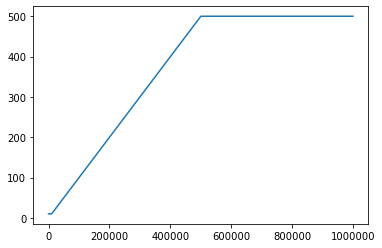

In [719]:
# Visualizing how n_candidates changes as a function of vocab size.
x = np.arange(0, 1_000_000, 1_000)
y = np.clip(x // 1000, 10, 500)
plt.plot(x, y)

In [718]:
class LSHDict(dict):
    """Dictionary that returns the value corresponding to a key's nearest
    neighbor if the key isn't present in the dict. This is intended for use
    as a word2index dict when using embeddings in deep learning: e.g. if we
    have domain embeddings for the top 100k websites, some of our options for 
    dealing with unknown domains are:
    
    1. Encode all of them as <UNK>. This loses a lot of information.
    2. Create a FuzzyKeyDict which will search for similar keys using variants
    of Levenshtein distance. Lookup is O(N) and for 100k domains, that comes
    out to 0.6 seconds per item. We might have thousands or millions of 
    lookups over the course of training so this can be a significant cost.
    3. Create an LSHDict (lookups are O(1)). Indexing into the dict as usual 
    (e.g. my_lsh_dict[key]) will provide the key's index if present and the
    (approximate) nearest neighbor's index otherwise. Either way, the result
    can be used to index into your embedding layer. 
    4. Create an LSHDict and use the `similar_values` method to return n>1
    neighbors. Then pass their indices to an Embedding layer and 
    compute the sum/average/weighted average of the results. This may be 
    preferable to #3 cases such as web domain lookup, where similar URLs are
    not guaranteed to represent similar sites. (This is basically
    equivalent to an EmbeddingBag layer, but in torch that doesn't store
    intermediate representations so we wouldn't be able to use our pretrained
    embeddings.)
    """

    def __init__(self, data, n_candidates=None, n_keys=3, ngram_size=3,
                 scorer=fuzz.ratio):
        """Update an LSHDict after instantiation is slow so we require the 
        user to pass in data immediately.
        
        Parameters
        ----------
        """
        if len(data) < 10_000 and len(next(iter(data))) < 100:
            warnings.warn(
                'It looks like you\'re working with a relatively small '
                'amount of data. FuzzyKeyDict may be fast enough for your '
                'use case and would provide the set of strictly most similar '
                'keys rather than an approximation of that set.'
            )
            
        super().__init__(data)
        self.scorer = scorer
        self.hash_word = partial(lsh_hash_word, n=ngram_size)
        self.forest = MinHashLSHForest(num_perm=128)
        self._initialize_forest()
        
        # Datasketch's LSH implementation usually gives pretty decent results
        # even with numbers as low as 5-10, but increasing that by a factor of
        # 10 comes with minimal time cost: Fuzzywuzzy matching doesn't get 
        # particularly slow until we get into the thousands. The fact that 
        # we cap this at 500 makes this lookup asymptotically O(1) while
        # FuzzyKeyDict's is O(N).
        self.n_candidates = n_candidates or np.clip(len(self) // 1_000,
                                                    20, 500)
        self.n_keys = n_keys

    def __getitem__(self, key):
        """If a key is present, its corresponding value is returned. If not,
        the value for its (estimated) closest match is returned.
        """
        try:
            return super().__getitem__(key)
        except KeyError:
            key = self.similar_keys(key, return_similarities=False, 
                                    n_keys=1)[0]
            return self[key]
        
    def __setitem__(self, key, val):
        """Try to add keys all at once in the constructor because adding new
        keys can be extremely slow.
        """
        super().__setitem__(key, val)
        self._update_forest(key, val)
        
    def _update_forest(self, key, val, index=True):
        """Used in __setitem__ to update our LSH Forest. Forest's index method
        seems to recompute everything so adding items to a large LSHDict will
        be incredibly slow. Luckily, our deep learning use case rarely/never
        requires us to update object2index dicts after instantiation so that's
        not as troubling as it might seem.
        
        Parameters
        ----------
        key: str
        val: any
        index: bool
            If True, reindex the forest (essentially making the key 
            queryable). This should be False when initializing the forest so
            we just index once after everything's been added.
        """
        self.forest.add(key, self.hash_word(key))
        if index: self.forest.index()
        
    def _initialize_forest(self):
        """Called once in __init__ to add all items to LSH Forest. This is
        necessary because dict specifically calls its own __setitem__, not
        its children's.
        """
        for k, v in self.items():
            self._update_forest(k, v, False)
        self.forest.index()
    
    def similar_keys(self, key, return_similarities=False, 
                     n_candidates=None, n_keys=None, scorer=None):
        """Find a list of similar keys. This is used in __getitem__ but can
        also be useful as a user-facing method if you want to get more than
        1 neighbor or you want to get similarity scores as well.
        
        Parameters
        ----------
        key: str
            Word/URL/etc. to find similar keys to.
        return_similarities: bool
            If True, return a list of tuples where each item is (key, score).
            If False, just return a list of keys.
        n_candidates: int or None
            Number of similar candidats to retrieve. This uses Jaccard
            Similarity which isn't always a great metric for string 
            similarity. This is also where the LSH comes in so they're not
            strictly the n best candidates, but rather a close approximation
            of that set. If None, this will fall back to self.n_candidates.
            Keep in mind this determines how many keys to 
        n_keys: int or None
            Number of similar keys to return. If None, this will fall back to
            self.n_keys. 
        scorer: function or None
            Fuzzywuzzy scoring function, e.g. fuzz.ratio or 
            fuzz.partial_ratio, which will be used to score each candidate and
            select which to return. Higher scores indicate higher levels of
            similarity. If None, this will fall back to self.scorer.
        """
        candidates = self.forest.query(self.hash_word(key), 
                                       n_candidates or self.n_candidates)
        if not candidates: raise KeyError('No similar keys found.')
            
        # List of (key, score) where higher means more similar.
        pairs = process.extract(key, candidates, 
                                limit=n_keys or self.n_keys,
                                scorer=scorer or self.scorer)
        if return_similarities: return pairs
        return [p[0] for p in pairs]
    
    def similar_values(self, key, **kwargs):
        """TODO: docs
        # TODO: consider adding similar_keys kwargs here, either manually or
        otherwise.
        """
        return [self[k] for k in self.similar_keys(key, **kwargs)]

In [695]:
# df = pd.read_csv('../data/top500Domains.csv', usecols=['Root Domain', 'Rank'])
# df = df.rename(columns={'Root Domain': 'domain', 'Rank': 'rank_'})
# d2i = dict(zip(df.domain, df.rank_))

In [696]:
d2i = dict(df.head(1000).set_index('host')['#pr_pos'])

In [697]:
ld = LSHDict(d2i, 3)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: It looks like you're working with a relatively small amount of data. FuzzyKeyDict may be fast enough for your use case and would provide the set of strictly most similar keys rather than an approximation of that set.


In [698]:
fd = FuzzyKeyDict(d2i)

In [699]:
ld['youtube.com']

5

In [700]:
ld['goguardian.com']

149

In [715]:
ld.similar_keys('goguardian.com', True, n_candidates=50, n_keys=4)

[('theguardian.com', 83),
 ('co.guardian.uk', 71),
 ('domain.com', 67),
 ('collegian.com', 67)]

In [712]:
ld.similar_values('goguardian.com', n_candidates=50, n_keys=4)

[149, 972, 2021, 1149]

In [713]:
fd['goguardian.com']

[149, 972, 2299]

In [714]:
fd.similar_keys('goguardian.com', True)

[('theguardian.com', 83), ('co.guardian.uk', 71), ('yourdomain.com', 71)]

In [704]:
ld['miniclip.com']

431

In [705]:
ld.similar_keys('bloodyelbow.com', n_candidates=100)

['zillow.com', 'bloomberg.com', 'googleblog.com']

In [706]:
fd.similar_keys('bloodyelbow.com', True)

[('globo.com', 67), ('bloomberg.com', 64), ('billboard.com', 64)]

In [707]:
ld['pausd.edu']

1401

In [708]:
fd.similar_keys('pausd.edu', True)

[('ucsd.edu', 82), ('psu.edu', 75), ('usc.edu', 75)]

In [709]:
ld['addictinggames.com']

1691

In [710]:
ld.similar_keys('addictinggames.com', n_candidates=100)

['latimes.com', 'ibtimes.com', 'indiatimes.com']

In [711]:
fd.similar_keys('addictinggames.com', True)

[('oxforddictionaries.com', 70), ('latimes.com', 69), ('addthis.com', 69)]

### Toy Example

In [609]:
w2i = dict(zip(ws, np.random.permutation(len(ws))))
w2i

{'dino': 2,
 'rhino': 1,
 'dog': 7,
 'cat': 3,
 'lion': 8,
 'tyrannosaurus rex': 0,
 'tiger': 5,
 'owl': 9,
 'rhinocerous': 4,
 'kino': 6}

In [331]:
ld = LSHDict(w2i)
ld

{'dino': 6,
 'rhino': 3,
 'dog': 5,
 'cat': 1,
 'lion': 0,
 'tyrannosaurus rex': 8,
 'tiger': 4,
 'owl': 9,
 'rhinocerous': 2,
 'kino': 7}

In [333]:
ld['dog'], ld['sea lion'], ld['munchkin'], ld['kitten']

['lion']
['kino']
[]


(5, 0, 7, -1)

In [321]:
ld.forest.query(lsh_hash_word('estion'), 3)

['lion']

In [323]:
ld.forest.query(lsh_hash_word('brontosaur'), 3)

['tyrannosaurus rex']

In [322]:
ld['dragon'] = 6